In [ ]:
!pip install prophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.7 MB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 45 kB 3.0 MB/s 
ERROR: Operation cancelled by user


# Bring in the Required Libraries

These libraries are used for the following purposes:

1. `pandas` is used for managing datasets.
2. `matplotlib.pyplot` is used for plotting graphs.
3. `numpy` is used for performing matrix and linear algebra operations.
4. `datetime` is used to work with dates in the dataset.
5. `Prophet` from `prophet` is used for performing the time-series analysis.
6. `plot_forecast_component` from `prophet.plot` is used for plotting the trend.
7. `cross_validation` from `prophet.diagnostics` is used for performing cross validation on the time-series data.
8. `performance_metrics` from `prophet.diagnostics` is used to calculate various formal metrics for measuring model performance.
9. `plot_cross_validation_metric` from `prophet.plot` is used to plot the various formal performance metrics of the model.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from prophet import Prophet
from prophet.plot import plot_forecast_component
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

# Load the Data

In [ ]:
df = pd.read_csv("inference_csv1.tmp.csv")
df.head()

,ds,y
0,2016-01,1096548
1,2016-10,1292172
2,2016-11,1243075
3,2016-12,1178370
4,2017-01,1110016


# Create the Model

In [ ]:
model = Prophet()

# Fit the Model

From here, we can see that Prophet has already selected the *yearly* trend and disabled the *monthly* and *daily* trends as expected for this dataset.

In [ ]:
model.fit(df)

# Predict on Input Dataset

Here, we perform prediction on the input dataset to see how well the model fits the input dataset.

In [ ]:
prediction = model.predict(df)

Here,

* `yhat` refers to the predicted output for each input point.
* `yhat_lower` and `yhat_upper` refers to the range in which yhat will be present even if the actual prediction is wrong. This range is known as the **Confidence Interval**.
* `trend` refers to how the data is changing gradually over years.
* `additive_terms` refers to the value which must be added to `trend` to get `yhat`.

In [ ]:
prediction.tail(12)[['ds', 'yhat', 'yhat_lower', 'yhat_upper', 'trend', 'additive_terms']]

,ds,yhat,yhat_lower,yhat_upper,trend,additive_terms
29,2020-10-01,1.280097e+06,1.052063e+06,1.515058e+06,61261.917848,1.218835e+06
30,2020-11-01,1.242796e+06,1.011789e+06,1.480003e+06,59989.314917,1.182806e+06
31,2020-12-01,1.166637e+06,9.334683e+05,1.411061e+06,58757.763715,1.107879e+06
32,2021-01-01,6.103729e+05,3.727859e+05,8.479296e+05,57485.160823,5.528878e+05
33,2021-02-01,7.027499e+05,4.681870e+05,9.411264e+05,56212.557931,6.465373e+05
34,2021-03-01,7.867072e+05,5.475929e+05,1.024362e+06,55063.110158,7.316440e+05
35,2021-04-01,1.145693e+06,9.197885e+05,1.385419e+06,53790.507266,1.091903e+06
36,2021-05-01,1.182903e+06,9.631729e+05,1.437782e+06,52558.956080,1.130344e+06
37,2021-09-01,1.308451e+06,1.079503e+06,1.549000e+06,47509.596219,1.260941e+06
38,2021-10-01,1.241297e+06,1.001111e+06,1.467916e+06,46278.045033,1.195019e+06


# Plot the Predictions on Input Dataset

The **black dots** refers to the actual data points as present in the dataset. The **dark blue line** refers to the *yhat* line. This is the value predicted by the model at each time instance. The **light blue region** refers to the confidence interval. And we can see that we have got 2 outliers in the dataset.

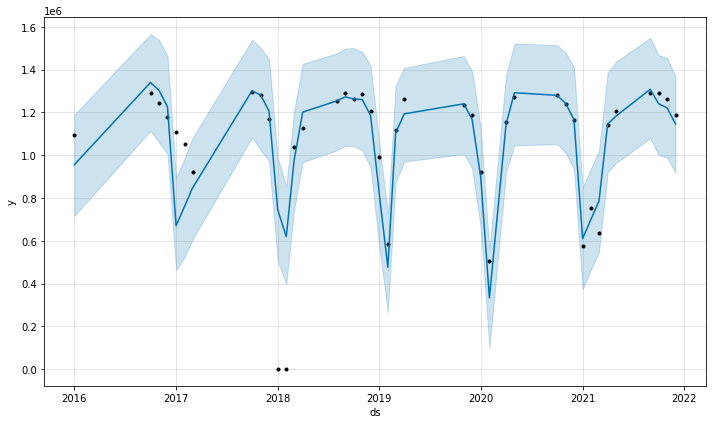

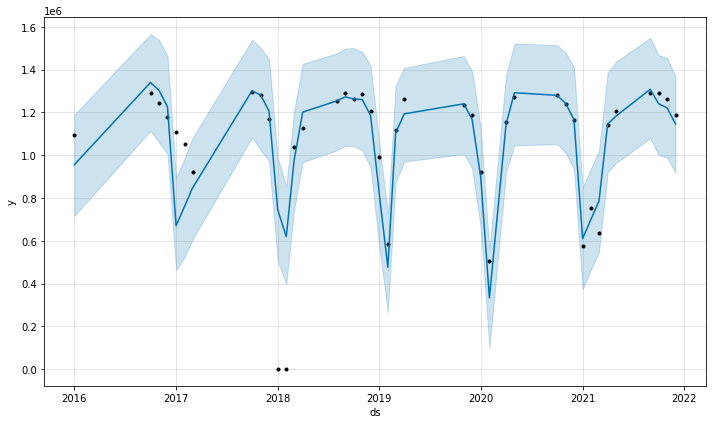

In [ ]:
model.plot(prediction)

# Plot Trend of the Data over Years

Here we can see the area under moderate and thick forest is slowly decreasing over the years.

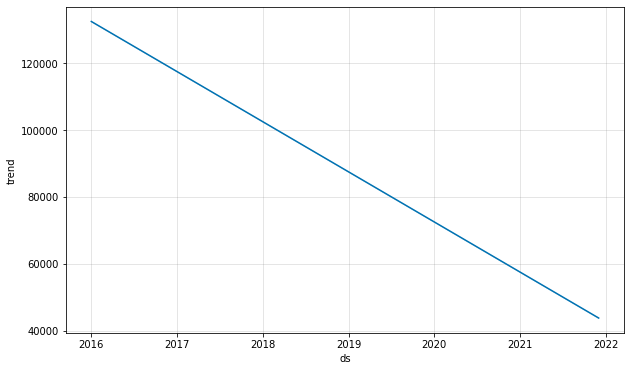

In [ ]:
plot_forecast_component(model, prediction, name = 'trend')

# Manually Plot the Trend (only for testing)

This is to confirm that the trend plotted above is actually correct. This is because the trend plotted before using the *prediction* dataset was not giving a straight line. It appears as if the problem was with the x axis values. There, matplotlib was automatically generating the x axis labels from the data while here, we are generating the x axis labels using the dates.

**Note: This does not need to be included in the documentation as this is only for testing purposes.**

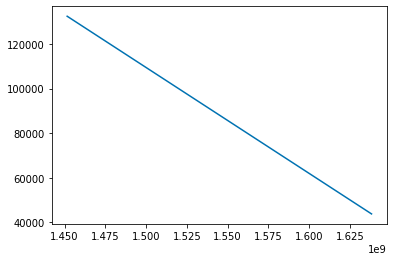

In [ ]:
fcst_t = prediction['ds'].dt.to_pydatetime()
x_timestamps = list(map(lambda x: x.timestamp(), prediction['ds'].tolist()))
plt.plot(x_timestamps, prediction['trend'], ls = '-', c = '#0072B2')
plt.show()

# Calculate the Slope of Trendline

The slope of the trendline signifies whether the area is having deforestation or reforestation. A negative slope represent deforestation while a positive slope represent reforestation. Here, we calculate the slope of the line and see that deforestation is prevalent in this region as also visually confirmed from the RGB images.

We have taken only the last 2 data points for calculating the slope. This is because the trend can change over time and the line is not guaranteed to be straight for all datasets. So if the trend changes over time, and we consider all the data points, then the slope cannot be calculated and the output will be errorneous.

In [ ]:
x_timestamps = list(map(lambda x: x.timestamp(), prediction['ds'].tolist()))
slope, intercept = np.polyfit(x_timestamps[-2:], prediction['trend'][-2:], deg = 1)
slope

-0.000475135513540762

In [ ]:
angle = np.rad2deg(np.arctan2(prediction['trend'].tolist()[-1] - prediction['trend'].tolist()[-2], x_timestamps[-2] - x_timestamps[-1]))
angle

-179.97277674387257

# Perform Cross-Validation to Check Model Performance

Perform **cross-validation** on the training dataset. Initially a period of 4 years is taken to train the model (`initial` parameter) and 1 year (the 5th year) is used to validate the model (`horizon` parameter). Then another year (5th year) is added to the training data (`period` parameter) and the 6th year is used for validation. This process is performed repeatedly for the entire dataset.

Blog on Cross-Validation: [https://robjhyndman.com/hyndsight/tscv/](https://robjhyndman.com/hyndsight/tscv/)

In this dataset, we have data ranging from 2016 to 2021. So, initially if we add data worth of 4 years to training, then we are left with only the 5th year (2021) for validation. We add 4 year worth of training data initially because we do not have any data for the month of *May* for any year before 2020. Hence, we are only left with 1 iteration of cross-validation.

Here, we can observe the `y` and `yhat` values for all the available data points in 2021. The dates of the available data points are shown in `ds` column. The cutoff is the December of 2021 as we had 4 years worth of data in the training set.

In [ ]:
df_cv = cross_validation(model, horizon = "365 days", initial = "1460 days", period = "365 days")

INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-01 00:00:00 and 2020-12-01 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 24.


In [ ]:
df_cv

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-01,6.141665e+05,3.562572e+05,8.631440e+05,575320,2020-12-01
1,2021-02-01,6.359157e+05,3.879205e+05,8.935495e+05,752044,2020-12-01
2,2021-03-01,8.769729e+05,6.157857e+05,1.153807e+06,635369,2020-12-01
3,2021-04-01,1.139995e+06,8.922064e+05,1.407464e+06,1143471,2020-12-01
4,2021-05-01,1.063218e+06,8.015402e+05,1.314505e+06,1204999,2020-12-01
5,2021-09-01,1.405399e+06,1.158253e+06,1.658382e+06,1290356,2020-12-01
6,2021-10-01,1.227106e+06,9.629942e+05,1.489139e+06,1291349,2020-12-01
7,2021-11-01,1.208090e+06,9.541530e+05,1.466357e+06,1262746,2020-12-01
8,2021-12-01,1.132253e+06,8.804058e+05,1.389207e+06,1187600,2020-12-01


From the above dataset, it may be difficult to observe the accuracy (a rough estimate of how the model is performing) of the model. Here we add that **accuracy** column to the dataset. Again, this is an informal way of looking at the performance of the model and is only used for reference purpose. We will look at more formal metrics of performance later on.

From below, we can see that most of the accuracy values we get are quite respectable for our purposes.

In [ ]:
df_accuracy = df_cv.copy()
df_accuracy["accuracy"] = 1 - ((df_accuracy["y"] - df_accuracy["yhat"]) / df_accuracy["y"]).abs()
df_accuracy

,ds,yhat,yhat_lower,yhat_upper,y,cutoff,accuracy
0,2021-01-01,6.141665e+05,3.562572e+05,8.631440e+05,575320,2020-12-01,0.932478
1,2021-02-01,6.359157e+05,3.879205e+05,8.935495e+05,752044,2020-12-01,0.845583
2,2021-03-01,8.769729e+05,6.157857e+05,1.153807e+06,635369,2020-12-01,0.619742
3,2021-04-01,1.139995e+06,8.922064e+05,1.407464e+06,1143471,2020-12-01,0.996960
4,2021-05-01,1.063218e+06,8.015402e+05,1.314505e+06,1204999,2020-12-01,0.882339
5,2021-09-01,1.405399e+06,1.158253e+06,1.658382e+06,1290356,2020-12-01,0.910844
6,2021-10-01,1.227106e+06,9.629942e+05,1.489139e+06,1291349,2020-12-01,0.950251
7,2021-11-01,1.208090e+06,9.541530e+05,1.466357e+06,1262746,2020-12-01,0.956716
8,2021-12-01,1.132253e+06,8.804058e+05,1.389207e+06,1187600,2020-12-01,0.953396


This is a plot of the accuracy values we obtained above.

We see that most of our accuracy values are around **90%** while a single point is around **65%**. This is quite workable for our purposes.

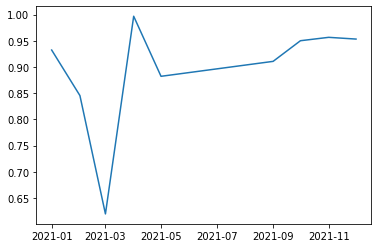

In [ ]:
df_sorted = df_accuracy.sort_values("ds")
plt.plot(df_sorted["ds"], df_sorted["accuracy"])
plt.show()

# Formal Performance Metrics

We print some formal performance metrics for our model.

More data can be found in [https://facebook.github.io/prophet/docs/diagnostics.html](https://facebook.github.io/prophet/docs/diagnostics.html).

We plot the `mape` or **Mean Absolute Percent Error** of the model. We can see that mostly, the error of our model lies around **10%** with a single value around **38%** at around the **90 days** mark.

In [ ]:
df_performance = performance_metrics(df_cv)
df_performance

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,31 days,1.509049e+09,38846.480929,38846.480929,0.067522,0.067522,0.065316,1.0
1,62 days,1.348579e+10,116128.340367,116128.340367,0.154417,0.154417,0.167337,1.0
2,90 days,5.837247e+10,241603.949930,241603.949930,0.380258,0.380258,0.319510,1.0
3,121 days,1.208384e+07,3476.181917,3476.181917,0.003040,0.003040,0.003045,1.0
4,151 days,2.010179e+10,141780.794835,141780.794835,0.117661,0.117661,0.125015,1.0
5,274 days,1.323481e+10,115042.660276,115042.660276,0.089156,0.089156,0.085351,1.0
6,304 days,4.127225e+09,64243.484941,64243.484941,0.049749,0.049749,0.051018,1.0
7,335 days,2.987329e+09,54656.460168,54656.460168,0.043284,0.043284,0.044241,1.0
8,365 days,3.063321e+09,55347.280648,55347.280648,0.046604,0.046604,0.047716,1.0


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:539: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:540: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


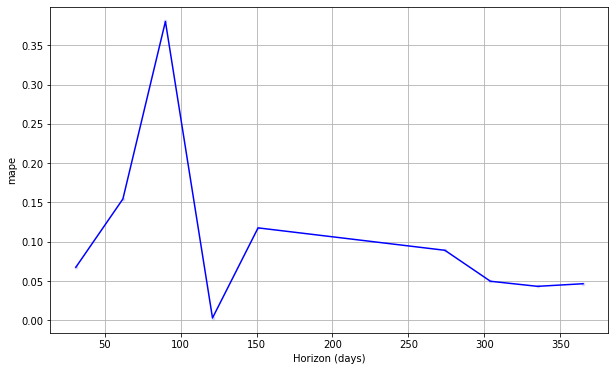

In [ ]:
figure = plot_cross_validation_metric(df_cv, metric = "mape")